# LangGraph Command & Edgeless Graphs: Dynamic Multi-Agent Workflows

This notebook explores LangGraph's **Command** feature for building dynamic, edgeless workflows where nodes can decide which node to execute next at runtime.

## What You'll Learn
1. **Command Type:** Using LangGraph's Command to control dynamic routing
2. **Edgeless Graphs:** Building workflows without predefined edges
3. **Multi-Agent Handoffs:** Dynamic agent-to-agent communication
4. **Hierarchical Agents:** Parent-child agent architectures
5. **Dynamic Routing:** Runtime decision making for workflow paths

## Setup and Installation

First, let's install the required packages and set up our environment.

In [ ]:
# Install required packages
!pip install langgraph langchain-openai python-dotenv

In [5]:
import os
from dotenv import load_dotenv
from typing import Dict, Any, List, Annotated, Literal
from typing_extensions import TypedDict

# LangGraph imports - Command is the key feature
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
from langgraph.graph.message import add_messages
from langgraph.prebuilt import create_react_agent

# LangChain imports
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.tools import tool

# Load environment variables
load_dotenv()

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## Configure OpenAI API

Make sure you have your OpenAI API key set up in your `.env` file or as an environment variable.

In [6]:
# Initialize OpenAI model
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.1,
    api_key=os.getenv("OPENAI_API_KEY")
)

# Test the connection
try:
    test_response = llm.invoke("Say 'Ready for LangGraph Command patterns!'")
    print(f"✅ OpenAI connection successful: {test_response.content}")
except Exception as e:
    print(f"❌ OpenAI connection failed: {e}")
    print("Please check your API key in the .env file")

✅ OpenAI connection successful: Ready for LangGraph Command patterns!


## 1. Understanding LangGraph Command

The Command type allows nodes to specify both:

1. **State updates** (like normal)
2. **Next node to execute** (the new capability)

**Basic Command Syntax**

In [ ]:
from langgraph.types import Command

# Basic state for our examples
class BasicState(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]
    current_task: str
    completed_tasks: List[str]
    user_input: str

# Example of a node that uses Command to control flow
def router_node(state: BasicState) -> Command[Literal["analyzer", "writer", "reviewer", END]]:
    """Node that decides which specialist to route to next"""

    user_input = state["user_input"]
    completed = state.get("completed_tasks", [])

    # Determine next action based on input and completed tasks
    if "analyze" in user_input.lower() and "analysis" not in completed:
        next_node = "analyzer"
        task = "text_analysis"
    elif "write" in user_input.lower() and "writing" not in completed:
        next_node = "writer"
        task = "content_writing"
    elif "review" in user_input.lower() and "review" not in completed:
        next_node = "reviewer"
        task = "content_review"
    else:
        # All tasks done or no clear direction
        next_node = END
        task = "completed"

    return Command(
        goto=next_node,
        update={
            "current_task": task,
            "messages": [AIMessage(content=f"Routing to: {next_node}")]
        }
    )

print("✅ Basic Command example defined!")

**Specialist Agent Nodes**

In [ ]:
def analyzer_node(state: BasicState) -> Command[Literal["writer", "reviewer", END]]:
    """Analyzes text and decides what to do next"""

    prompt = ChatPromptTemplate.from_template(
        "Analyze the following text and provide insights:\n\n{text}\n\n"
        "Focus on: tone, key themes, structure, and audience."
    )

    chain = prompt | llm
    result = chain.invoke({"text": state["user_input"]})

    completed = state.get("completed_tasks", []) + ["analysis"]

    # Decide next step based on analysis
    if "write" in state["user_input"].lower():
        next_node = "writer"
    elif len(completed) >= 2:  # If we've done multiple tasks
        next_node = END
    else:
        next_node = "reviewer"

    return Command(
        goto=next_node,
        update={
            "messages": [AIMessage(content=f"Analysis complete: {result.content}")],
            "completed_tasks": completed,
            "current_task": "analysis_done"
        }
    )

def writer_node(state: BasicState) -> Command[Literal["analyzer", "reviewer", END]]:
    """Writes content and decides next action"""

    # Check if we have analysis to work with
    analysis_available = any("Analysis" in msg.content for msg in state.get("messages", []) if isinstance(msg, AIMessage))

    if analysis_available:
        prompt = ChatPromptTemplate.from_template(
            "Based on the previous analysis, write engaging content about:\n{topic}\n\n"
            "Make it informative and well-structured."
        )
    else:
        prompt = ChatPromptTemplate.from_template(
            "Write engaging content about:\n{topic}\n\n"
            "Make it informative and well-structured."
        )

    chain = prompt | llm
    result = chain.invoke({"topic": state["user_input"]})

    completed = state.get("completed_tasks", []) + ["writing"]

    # Always go to reviewer after writing
    return Command(
        goto="reviewer",
        update={
            "messages": [AIMessage(content=f"Content written: {result.content}")],
            "completed_tasks": completed,
            "current_task": "writing_done"
        }
    )

def reviewer_node(state: BasicState) -> Command[Literal["writer", "analyzer", END]]:
    """Reviews content and decides if revision is needed"""

    # Get the last written content
    last_content = ""
    for msg in reversed(state.get("messages", [])):
        if isinstance(msg, AIMessage) and "Content written:" in msg.content:
            last_content = msg.content.replace("Content written: ", "")
            break

    if not last_content:
        # No content to review, redirect to writer
        return Command(
            goto="writer",
            update={
                "messages": [AIMessage(content="No content found to review. Redirecting to writer.")],
                "current_task": "redirect_to_writer"
            }
        )

    prompt = ChatPromptTemplate.from_template(
        "Review the following content for quality, clarity, and completeness:\n\n{content}\n\n"
        "Provide feedback and rate from 1-10. If score is below 7, suggest improvements."
    )

    chain = prompt | llm
    result = chain.invoke({"content": last_content})

    completed = state.get("completed_tasks", []) + ["review"]

    # Simple logic: if "improve" or low score in review, go back to writer
    if "improve" in result.content.lower() or any(str(i) in result.content for i in range(1, 7)):
        next_node = "writer"
        task = "revision_needed"
    else:
        next_node = END
        task = "review_complete"

    return Command(
        goto=next_node,
        update={
            "messages": [AIMessage(content=f"Review complete: {result.content}")],
            "completed_tasks": completed,
            "current_task": task
        }
    )

print("✅ Specialist agent nodes with Command routing defined!")

**Creating the Edgeless Graph**

In [ ]:
def create_edgeless_workflow():
    """Create an edgeless workflow using Command for dynamic routing"""

    workflow = StateGraph(BasicState)

    # Add all nodes
    workflow.add_node("router", router_node)
    workflow.add_node("analyzer", analyzer_node)
    workflow.add_node("writer", writer_node)
    workflow.add_node("reviewer", reviewer_node)

    # Only define the entry point - all other routing is handled by Command!
    workflow.add_edge(START, "router")

    return workflow.compile()

edgeless_app = create_edgeless_workflow()
print("✅ Edgeless workflow created with Command routing!")

**Testing the Edgeless Workflow**

In [ ]:
# Test 1: Request analysis and writing
print("🧪 Test 1: Analysis + Writing Request")
print("=" * 50)

user_input = "Please analyze this text about AI in healthcare and then write a summary: AI is revolutionizing medical diagnosis through machine learning algorithms."

try:
    result = edgeless_app.invoke({
        "user_input": user_input,
        "messages": [HumanMessage(content=user_input)]
    })

    print(f"📊 Final Task: {result['current_task']}")
    print(f"✅ Completed Tasks: {result['completed_tasks']}")
    print("\n💬 Workflow Messages:")
    for i, msg in enumerate(result["messages"], 1):
        print(f"{i}. {type(msg).__name__}: {msg.content[:100]}...")

    print(f"\n🎯 Workflow Status: {result['current_task']}")

except Exception as e:
    print(f"❌ Error: {e}")

In [ ]:
# Test 2: Just writing request
print("\n🧪 Test 2: Writing Only Request")
print("=" * 50)

user_input2 = "Write an engaging article about the benefits of renewable energy"

try:
    result2 = edgeless_app.invoke({
        "user_input": user_input2,
        "messages": [HumanMessage(content=user_input2)]
    })

    print(f"📊 Final Task: {result2['current_task']}")
    print(f"✅ Completed Tasks: {result2['completed_tasks']}")
    print(f"\n🎯 Total Messages Generated: {len(result2['messages'])}")

    # Show the routing decisions
    routing_msgs = [msg.content for msg in result2["messages"] if "Routing to:" in msg.content]
    print(f"🧭 Routing Decisions: {routing_msgs}")

except Exception as e:
    print(f"❌ Error: {e}")

## 2. Multi-Agent Handoffs with Command

Now let's implement proper multi-agent handoffs using Command, similar to OpenAI's Swarm pattern.


**Multi-Agent State and Tools**

In [7]:
# Enhanced state for multi-agent system
class MultiAgentState(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]
    current_agent: str
    agent_handoffs: List[Dict[str, str]]
    task_context: Dict[str, Any]
    user_request: str
    final_response: str


print("✅ Multi-agent state defined!")

✅ Multi-agent state defined!


**Specialized Agent Nodes with Handoffs**

In [22]:
def supervisor_agent(state: MultiAgentState) -> Command[Literal["research_agent","communication_agent", "report_agent", END]]:
    """LLM-based routing agent that coordinates the overall workflow"""

    user_request = state["user_request"]
    context = state.get("task_context", {})
    completed_agents = [h["to_agent"] for h in state.get("agent_handoffs", [])]

    # LLM prompt that asks it to decide the next agent based on current context
    supervisor_prompt = ChatPromptTemplate.from_template("""
    You are the supervisor agent coordinating a multi-step task.

    Here is the user's request:
    {user_request}

    Context from previous agents:
    {context}

    Completed agents so far: {completed_agents}

    Decide which agent should handle the task next:
    - "research_agent" → for finding or gathering information
    - "report_agent" → for generating structured reports
    - "communication_agent" → for sending final notifications
    - "END" → if the task is complete

    Respond with JUST the agent name.
    """)

    chain = supervisor_prompt | llm
    result = chain.invoke({
        "user_request": user_request,
        "context": context,
        "completed_agents": completed_agents
    })

    next_node = result.content.strip().lower()

    if next_node not in {"research_agent", "report_agent", "communication_agent", "end"}:
        next_node = "research_agent"
        reason = "Fallback: LLM returned unknown agent"
    elif next_node == "end":
        next_node = END
        reason = "LLM decided the task is complete"
    else:
        reason = f"LLM routed to {next_node}"

    # Update handoffs if not ending
    handoffs = state.get("agent_handoffs", [])
    if next_node != END:
        handoffs.append({
            "from_agent": "supervisor",
            "to_agent": next_node,
            "reason": reason
        })

    return Command(
        goto=next_node,
        update={
            "current_agent": "completed" if next_node == END else next_node,
            "agent_handoffs": handoffs,
            "messages": [AIMessage(content=f"Supervisor: {reason}")]
        }
    )

In [26]:
def research_agent(state: MultiAgentState) -> Command[Literal["supervisor_agent"]]:
    """Agent that researches the user request"""

    user_request = state["user_request"]
    context = state.get("task_context", {})

    prompt = ChatPromptTemplate.from_template("""
    Research the user's request and summarize your findings.
    Request: {request}
    """)

    chain = prompt | llm
    result = chain.invoke({"request": user_request})
    findings = result.content.strip()

    updated_context = context.copy()
    updated_context["research_findings"] = findings

    return Command(
        goto="supervisor_agent",
        update={
            "task_context": updated_context,
            "messages": [AIMessage(content=f"Research Agent:\n{findings}")],
            "current_agent": "supervisor_agent"
        }
    )

In [27]:
def report_agent(state: MultiAgentState) -> Command[Literal["supervisor_agent"]]:
    """Agent that creates a report from research findings"""

    context = state.get("task_context", {})
    research = context.get("research_findings", "")

    prompt = ChatPromptTemplate.from_template("""
    Write a structured Markdown report based on the following research:
    {research}
    """)

    chain = prompt | llm
    result = chain.invoke({"research": research})
    report = result.content.strip()

    updated_context = context.copy()
    updated_context["generated_report"] = report

    return Command(
        goto="supervisor_agent",
        update={
            "task_context": updated_context,
            "messages": [AIMessage(content=f"Report Agent:\n{report[:500]}...")],
            "current_agent": "supervisor_agent"
        }
    )

In [28]:
import requests

def send_notification(payload: dict) -> str:
    webhook_url = "https://hooks.slack.com/services/..."  # replace with your real webhook
    message = payload.get("message", "No message provided")

    response = requests.post(webhook_url, json={"text": message})
    if response.status_code == 200:
        return "✅ Slack message sent"
    else:
        return f"❌ Slack error: {response.status_code} - {response.text}"

def communication_agent(state: MultiAgentState) -> Command[Literal["supervisor_agent"]]:
    """Agent that notifies the team via Slack"""

    context = state.get("task_context", {})
    report = context.get("generated_report", "")

    prompt = ChatPromptTemplate.from_template("""
    Summarize the content of the following report for team communication:
    {report}
    """)

    chain = prompt | llm
    result = chain.invoke({"report": report})
    message = result.content.strip()

    slack_result = send_notification({"message": message})

    updated_context = context.copy()
    updated_context["notified"] = True

    return Command(
        goto="supervisor_agent",
        update={
            "task_context": updated_context,
            "messages": [AIMessage(content=f"Communication Agent:\n{message}\n\n{slack_result}")],
            "current_agent": "supervisor_agent"
        }
    )


**Creating Multi-Agent Workflow**

In [29]:
def create_multi_agent_workflow():
    """Create multi-agent system with Command-based handoffs"""

    workflow = StateGraph(MultiAgentState)

    # Add agent nodes
    workflow.add_node("supervisor_agent", supervisor_agent)
    workflow.add_node("research_agent", research_agent)
    workflow.add_node("report_agent", report_agent)
    workflow.add_node("communication_agent", communication_agent)

    # Only entry point needed - Command handles all routing!
    workflow.add_edge(START, "supervisor_agent")

    return workflow.compile()

multi_agent_app = create_multi_agent_workflow()
print("✅ Multi-agent workflow with Command handoffs created!")

✅ Multi-agent workflow with Command handoffs created!


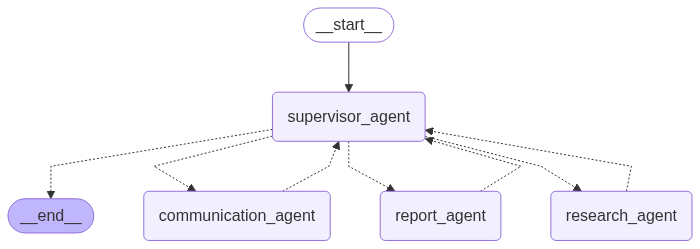

In [30]:
from IPython.display import Image, display

display(Image(multi_agent_app.get_graph().draw_mermaid_png()))

**Testing Multi-Agent Handoffs**

In [31]:
# Test multi-agent handoffs
print("🤖 Testing Multi-Agent Handoffs")
print("=" * 60)

user_request = "Research the latest trends in AI and create a report, then send it to the team"

try:
    result = multi_agent_app.invoke({
        "user_request": user_request,
        "messages": [HumanMessage(content=user_request)]
    })

    print("🔄 Agent Handoff Chain:")
    for i, handoff in enumerate(result["agent_handoffs"], 1):
        print(f"{i}. {handoff['from_agent']} → {handoff['to_agent']}: {handoff['reason']}")

    print(f"\n🎯 Final Agent: {result['current_agent']}")
    print(f"📋 Task Context Keys: {list(result['task_context'].keys())}")

    print("\n💬 Agent Messages:")
    for msg in result["messages"]:
        if isinstance(msg, AIMessage):
            print(f"  • {msg.content}")

    print(f"\n✅ Final Response: {result.get('final_response', 'No final response')[:200]}...")

except Exception as e:
    print(f"❌ Error: {e}")

🤖 Testing Multi-Agent Handoffs


🔄 Agent Handoff Chain:
1. supervisor → research_agent: LLM routed to research_agent
2. supervisor → report_agent: LLM routed to report_agent
3. supervisor → communication_agent: LLM routed to communication_agent

🎯 Final Agent: completed
📋 Task Context Keys: ['research_findings', 'generated_report', 'notified']

💬 Agent Messages:
  • Supervisor: LLM routed to research_agent
  • Research Agent:
### Report on Latest Trends in AI

#### 1. **Generative AI**
   - **Overview**: Generative AI has gained significant traction, particularly with models like OpenAI's GPT-4 and DALL-E, which can create text, images, and even music.
   - **Applications**: Content creation, design, and personalized marketing are key areas where generative AI is being utilized.
   - **Trends**: Increased focus on ethical considerations and bias mitigation in generative models.

#### 2. **AI in Healthcare**
   - **Overview**: AI is transforming healthcare through predictive analytics, personalized medicine, and diagno

## Conclusion: Command-Based Routing for Flexible Agent Handoffs
By leveraging the **Command** object in LangGraph, we enabled a clean and dynamic control flow between agents without hardcoding the graph structure. Each agent returns a Command that:
- Specifies the **next node to route to** (goto)
- **Updates the shared state**, such as messages, results, or context
- Optionally ends the workflow by routing to END

This pattern unlocks several benefits:
- **Centralized control, distributed logic:** Agents focus only on their task, while supervisor_agent handles routing based on updated state.
- **Dynamic branching:** Agents can adapt to intermediate outcomes, enabling retry loops, validations, or conditional rerouting.
- **Simplified graph definitions:** Since routing is returned from the nodes themselves, the static edges in the graph can remain minimal and generic.
- **Improved debuggability and transparency:** Agent handoffs are logged explicitly via the state, making workflows easy to audit and test.

Using Command transforms LangGraph from a static DAG engine into a **truly dynamic agent workflow coordinator** — ideal for LLM-based systems where execution paths evolve as the task progresses.

---

### Useful Resources:

- 🔗 [LangGraph Docs](https://langchain-ai.github.io/langgraph/)
- 🔗 [LangChain Docs](https://docs.langchain.com/)
- 🔗 [OpenAI Python SDK](https://github.com/openai/openai-python)

---

🤝 **Thanks for following along — happy building with LangGraph!**